In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Input folders
RAW_DATA_DIR = "../data/raw/"
INTERIM_DATA_DIR = "../data/interim/"
PROCESSED_DATA_DIR = "../data/processed/"

In [5]:
data = pd.read_csv(f'{INTERIM_DATA_DIR}7_with_climate_data.csv')
print(data.shape)
data.head()

(3331, 35)


,grower,farm,field,field_fvid,lat,lng,year,tmin,tmax,gdd,...,summer_temp_variability,summer_cold_days,winter_avg_temp,winter_hottest_temp,winter_coldest_temp,winter_heavy_rainfall_days,winter_temp_variability,winter_warm_day_count,winter_extreme_cold_days,spring_frost_free_days
0,Wisconsin Central Farms,WCF,1 Necedah,62992,44.057164,-90.040412,2014,44.815974,83.173633,13.772113,...,4.000550,10.0,-12.111905,7.0,-30.9,0.0,6.345407,0.0,58.0,8.0
1,Wisconsin Central Farms,WCF,13 Nepco N 1/2,62996,44.209406,-90.021382,2014,45.498328,79.713370,12.804045,...,4.098317,8.0,-12.090588,6.1,-31.1,0.0,6.696421,0.0,54.0,5.0
2,Wisconsin Central Farms,WCF,16 13th St,62999,44.100775,-90.050524,2014,45.224964,82.761841,14.263578,...,3.989022,10.0,-11.597778,7.0,-30.9,0.0,6.668776,0.0,59.0,8.0
3,Wisconsin Central Farms,WCF,26 Huebner,63009,44.171606,-89.975877,2014,45.584387,82.216665,13.292737,...,4.082081,8.0,-12.063333,6.1,-31.1,0.0,6.670267,0.0,58.0,5.0
4,Wisconsin Central Farms,WCF,7 N Home,63016,44.329762,-89.931300,2014,45.715179,78.727568,12.237354,...,4.098317,8.0,-12.090588,6.1,-31.1,0.0,6.696421,0.0,54.0,5.0


### Testing for outliers

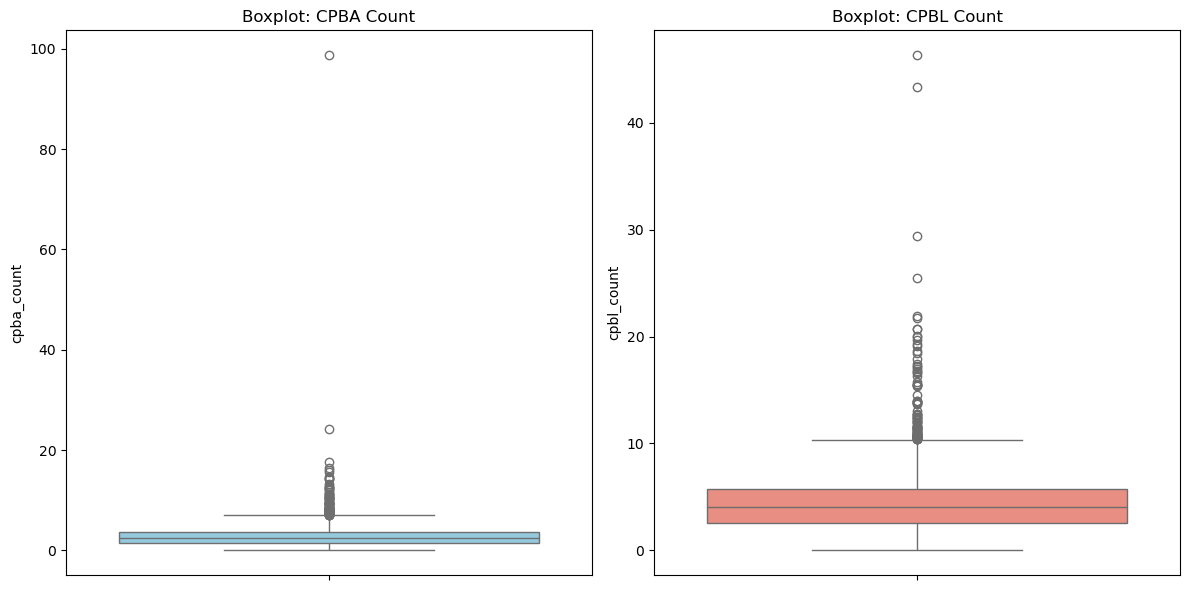

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(y=data['cpba_count'], ax=axs[0], color='skyblue')
axs[0].set_title('Boxplot: CPBA Count')

sns.boxplot(y=data['cpbl_count'], ax=axs[1], color='salmon')
axs[1].set_title('Boxplot: CPBL Count')

plt.tight_layout()
plt.show()

In [9]:
from scipy.stats import zscore
import numpy as np

z_cpba = np.abs(zscore(data['cpba_count']))
z_cpbl = np.abs(zscore(data['cpbl_count']))

outliers_z_cpba = (z_cpba > 3)
outliers_z_cpbl = (z_cpbl > 3)

print("CPBA count Z-score outliers:", outliers_z_cpba.sum())
print("CPBL count Z-score outliers:", outliers_z_cpbl.sum())

CPBA count Z-score outliers: 28
CPBL count Z-score outliers: 39


In [14]:
def count_iqr_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return ((series < lower) | (series > upper)).sum()

print("CPBA count IQR outliers:", count_iqr_outliers(data['cpba_count']))
print("CPBL count IQR outliers:", count_iqr_outliers(data['cpbl_count']))

CPBA count IQR outliers: 95
CPBL count IQR outliers: 93


In [16]:
# Calculate z-scores
z_cpba = np.abs(zscore(data['cpba_count'], nan_policy='omit'))
z_cpbl = np.abs(zscore(data['cpbl_count'], nan_policy='omit'))

# Mark outliers (z > 3)
outlier_mask = (z_cpba > 3) | (z_cpbl > 3)

print(f"Total outlier rows to remove: {outlier_mask.sum()}")

# Combine with NA removal
df_cleaned = data[~outlier_mask].dropna()

print("Shape before:", data.shape)
print("Shape after removing outliers and NAs:", df_cleaned.shape)

Total outlier rows to remove: 65
Shape before: (3331, 35)
Shape after removing outliers and NAs: (3266, 35)


## Checking for Multicollinearity

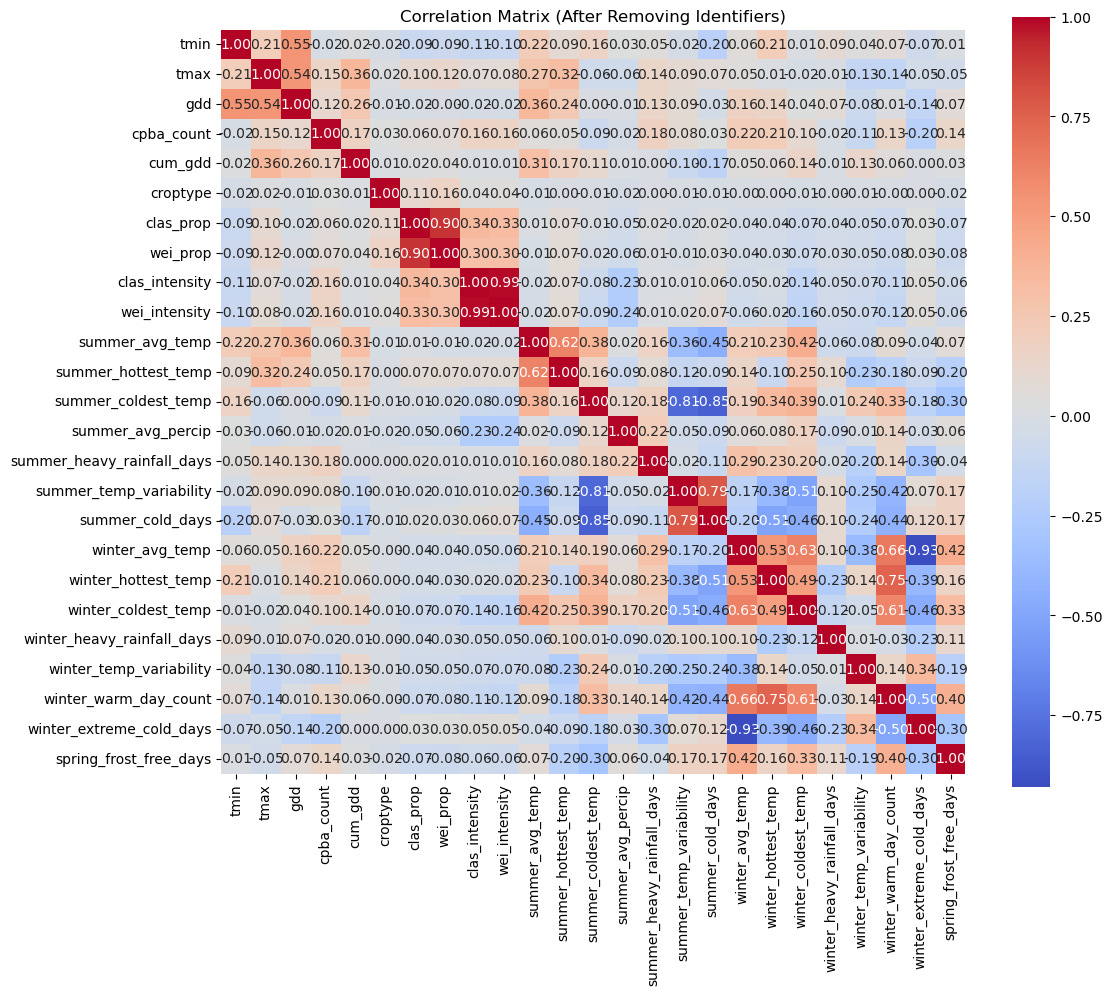

In [26]:
cols_id = ['grower', 'farm', 'field', 'field_fvid', 'lat', 'lng', 'year', 'cpba_value', 'cpbl_count', 'cpbl_value']
df_corr = df_cleaned.drop(columns=cols_id)

plt.figure(figsize=(12, 10))
sns.heatmap(df_corr.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (After Removing Identifiers)")
plt.show()

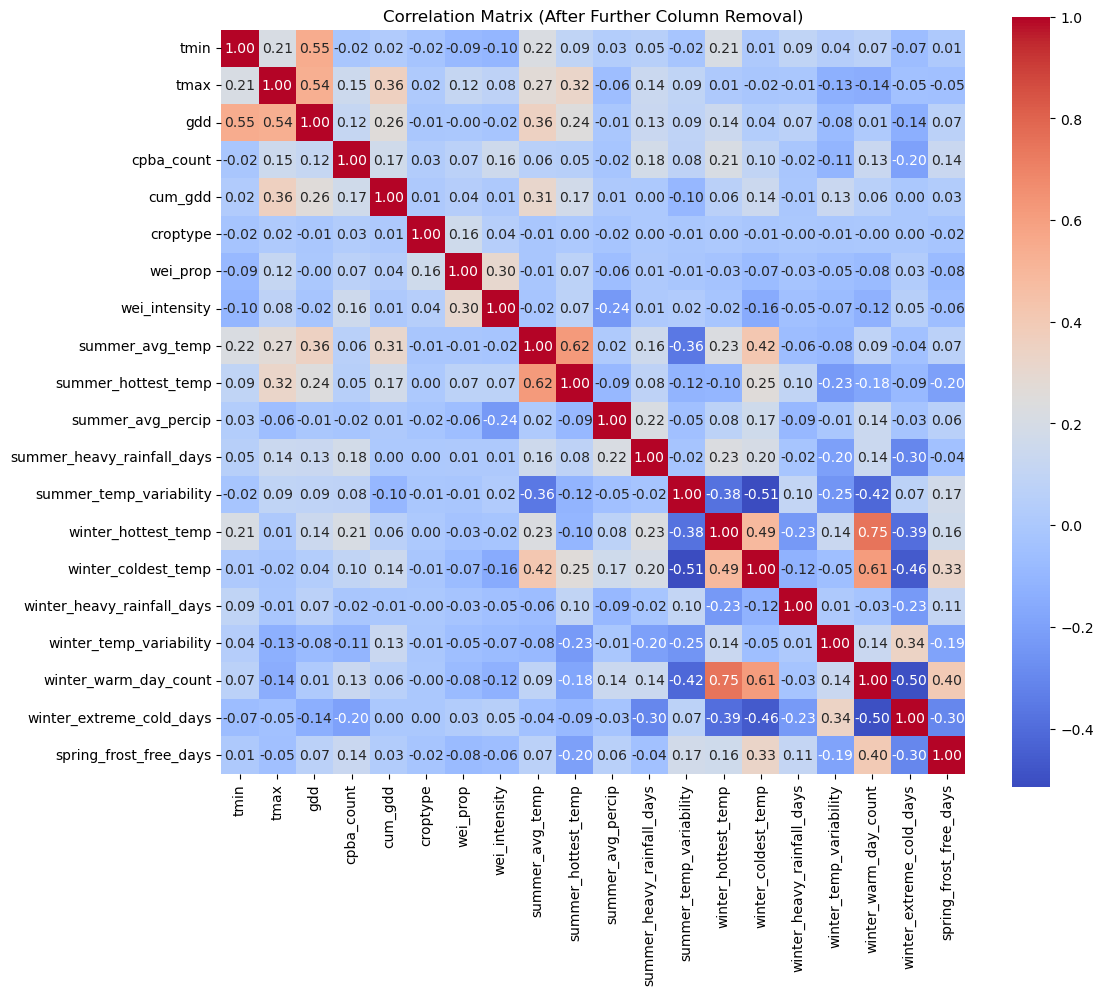

In [28]:
cols_corr2 = ['clas_prop','clas_intensity','summer_coldest_temp','summer_cold_days','winter_avg_temp']
df_corr2 = df_corr.drop(columns=cols_corr2)

plt.figure(figsize=(12, 10))
sns.heatmap(df_corr2.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (After Further Column Removal)")
plt.show()

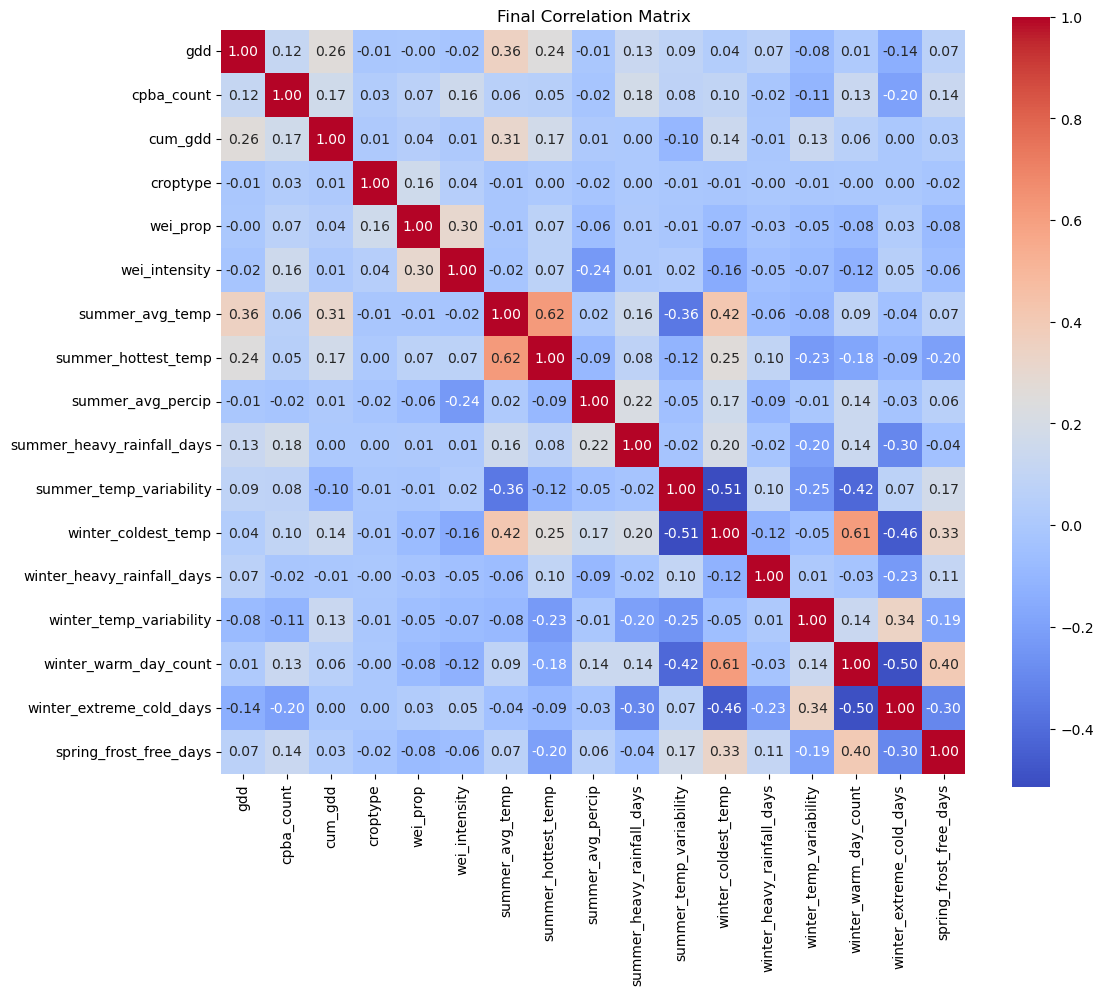

In [30]:
cols_corr3 = ['winter_hottest_temp','tmax', 'tmin']
df_corr3 = df_corr2.drop(columns=cols_corr3)

plt.figure(figsize=(12, 10))
sns.heatmap(df_corr3.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Final Correlation Matrix")
plt.show()

In [32]:
cols_final_drop = cols_corr2 + cols_corr3
final_data = df_cleaned.drop(columns=cols_final_drop)

final_data.to_csv(f"{PROCESSED_DATA_DIR}final_data_for_modeling.csv", index=False)

In [38]:
final_data.columns

Index(['grower', 'farm', 'field', 'field_fvid', 'lat', 'lng', 'year', 'gdd',
       'cpba_count', 'cpba_value', 'cpbl_count', 'cpbl_value', 'cum_gdd',
       'croptype', 'wei_prop', 'wei_intensity', 'summer_avg_temp',
       'summer_hottest_temp', 'summer_avg_percip',
       'summer_heavy_rainfall_days', 'summer_temp_variability',
       'winter_coldest_temp', 'winter_heavy_rainfall_days',
       'winter_temp_variability', 'winter_warm_day_count',
       'winter_extreme_cold_days', 'spring_frost_free_days'],
      dtype='object')

In [42]:
final_data.shape

(3266, 27)